
# Example 1: Basic Mann Model Fit

This example demonstrates fitting the Mann model eddy lifetime function to the Kaimal one-point spectra and cross-spectra.

For reference, the Mann eddy lifetime function is given by

\begin{align}\tau^{\mathrm{Mann}}(k)=\frac{(k L)^{-\frac{2}{3}}}{\sqrt{{ }_2 F_1\left(1 / 3,17 / 6 ; 4 / 3 ;-(k L)^{-2}\right)}}\,.\end{align}

This set of models it widely used for flat, homogeneous terrains.

``drdmannturb`` can also be used directly to generate the corresponding 3D turbulence field, as demonstrated in Examples 8 and 9.


## Import packages

First, we import the packages needed for this example.



In [1]:
import torch

from drdmannturb import EddyLifetimeType
from drdmannturb.parameters import (
    LossParameters,
    NNParameters,
    PhysicalParameters,
    ProblemParameters,
)
from drdmannturb.spectra_fitting import CalibrationProblem, OnePointSpectraDataGenerator

device = "cuda" if torch.cuda.is_available() else "cpu"

if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

Set up physical parameters and domain. We perform the spectra fitting over the
$k_1 z$ space $[10^{{-1}}, 10^2]$ with 20 points.



In [2]:
zref = 40  # reference height
ustar = 1.773  # friction velocity

# Intitial parameter guesses for fitting the Mann model
L = 0.59 * zref  # length scale
Gamma = 3.9  # time scale
sigma = 3.2 * ustar**2.0 / zref ** (2.0 / 3.0)  # magnitude (σ = αϵ^{2/3})

print(f"Physical Parameters: {L,Gamma,sigma}")

k1 = torch.logspace(-1, 2, 20) / zref

Physical Parameters: (23.599999999999998, 3.9, 0.8600574364289042)


## ``CalibrationProblem`` Construction
The following cell defines the ``CalibrationProblem`` using default values
for the ``NNParameters`` and ``LossParameters`` dataclasses.
Notice that ``EddyLifetimeType.MANN`` specifies the Mann model for the eddy lifetime
function, $\tau$, meaning no neural network is used in learning $\tau$.
Thus, we only learn the parameters $L$, $\Gamma$, and $\sigma$.



In [3]:
pb = CalibrationProblem(
    nn_params=NNParameters(),
    prob_params=ProblemParameters(eddy_lifetime=EddyLifetimeType.MANN, nepochs=2),
    loss_params=LossParameters(),
    phys_params=PhysicalParameters(
        L=L, Gamma=Gamma, sigma=sigma, ustar=ustar, domain=k1
    ),
    device=device,
)

## Data Generation
We now collect ``Data = (<data points>, <data values>)`` and specify the
reference height (``zref``) to be used during calibration. Note that ``DataType.KAIMAL``
is used by default.



In [4]:
Data = OnePointSpectraDataGenerator(data_points=k1, zref=zref, ustar=ustar).Data

The model is now fit to the provided spectra given in ``Data``.

Notee that the Mann eddy lifetime function relies on evaluating a hypergeometric function,
which only has a CPU implementation through ``Scipy``; cf. Example 7.

Having the necessary components, the model is "calibrated" (fit) to the provided spectra.



In [5]:
optimal_parameters = pb.calibrate(data=Data)

Initial loss: 0.036969418218857554


  0%|                                                                          | 0/2 [00:00<?, ?it/s]

 50%|█████████████████████████████████                                 | 1/2 [00:04<00:04,  4.88s/it]

100%|██████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.62s/it]

100%|██████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.96s/it]

Spectra fitting concluded with final loss: 0.025248721189996604


We conclude by printing the optimized parameters and generating a plot showing the
fit to the Kaimal spectra.



Optimal calibrated L        :  27.2532 
Optimal calibrated Γ        :   3.6762 
Optimal calibrated αϵ^{2/3} :   0.7988 


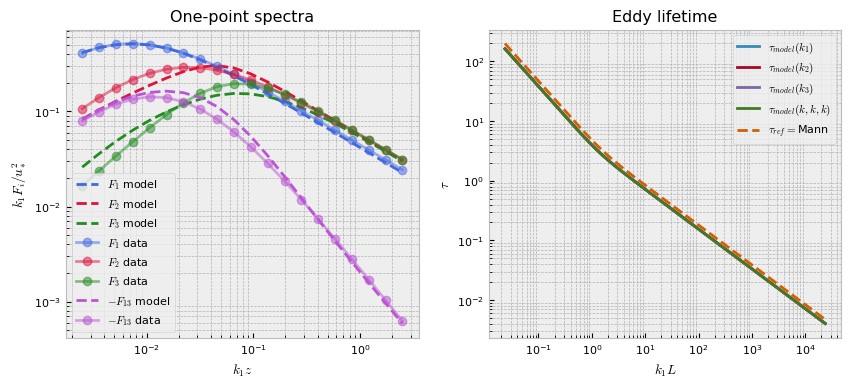

In [6]:
pb.print_calibrated_params()
pb.plot()